# OLS vs. Spatial Adapter Comparison with Tuning Parameter Selection

This notebook implements a comprehensive comparison between:
1. **TFT** - Linear baseline (no spatial term)
2. **Unregularized Spatial Adapter** - Neural spatial model without regularization
3. **Regularized Spatial Adapter** - Neural spatial model with optimized tau1, tau2 parameters

The experiment uses Optuna for hyperparameter optimization and evaluates performance across multiple random seeds.

my work: ols 換成 TFT 然後執行模擬

In [ ]:
# Import required libraries
import csv
import math
from pathlib import Path

import numpy as np
import optuna
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pytorch_lightning as pl
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import Tuple, Dict, Any, List

from darts import TimeSeries
from darts.models import TFTModel

from geospatial_neural_adapter.cpp_extensions import estimate_covariance
from geospatial_neural_adapter.utils.experiment import log_covariance_and_basis
from geospatial_neural_adapter.utils import (
    ModelCache,
    clear_gpu_memory,
    create_experiment_config,
    print_experiment_summary,
    get_device_info,
)
from geospatial_neural_adapter.models.spatial_basis_learner import SpatialBasisLearner
from geospatial_neural_adapter.models.spatial_neural_adapter import SpatialNeuralAdapter
from geospatial_neural_adapter.models.trend_model import TrendModel
from geospatial_neural_adapter.models.wrapper_examples.tft_wrapper import TFTWrapper
from geospatial_neural_adapter.data.generators import generate_time_synthetic_data
from geospatial_neural_adapter.data.preprocessing import (
    prepare_all_with_scaling,
    denormalize_predictions,
)
from geospatial_neural_adapter.metrics import compute_metrics
from geospatial_neural_adapter.models.pretrained_trend_model import (
    create_pretrained_trend_model,
)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Imports successful (TFT backbone enabled; all OLS utilities removed).")


/home/wangxc17/miniconda/envs/geospatial-neural-adapter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded spatial_utils from: /home/wangxc17/work/TFTModel-use/geospatial-neural-adapter-dev/geospatial_neural_adapter/cpp_extensions/spatial_utils.so
✅ Imports successful (TFT backbone enabled; all OLS utilities removed).


/home/wangxc17/miniconda/envs/geospatial-neural-adapter/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


## 1. Parameter Configuration and Setup

In [ ]:
# Experiment Configuration
EXPERIMENT_CONFIG = {
    'seed': 42,
    'n_time_steps': 1024//2,
    'n_locations': 512//2,
    'noise_std': 4.0,
    'eigenvalue': 16.0,
    'latent_dim': 1,
    'ckpt_dir': "admm_bcd_ckpts",
}

SPLIT_CONFIG = {
    "train_ratio": 0.70,
    "val_ratio": 0.15,   
}

TFT_CONFIG = {
    "input_chunk_length": 48,
    "output_chunk_length": 1,
    "hidden_size": 64,
    "lstm_layers": 1,
    "num_attention_heads": 4,
    "dropout": 0.10,
    "batch_size": 64,
    "n_epochs": 10,  #30
    "random_state": 42,
    "add_relative_index": True,
}

PL_TRAINER_KWARGS = (
    {"accelerator": "gpu", "devices": 1,
     "logger": True,                 
     "enable_progress_bar": True,   
     "enable_model_summary": False,
     "num_sanity_val_steps": 0}
    if torch.cuda.is_available()
    else {"accelerator": "cpu", "devices": 1,
          "logger": True,
          "enable_progress_bar": True,
          "enable_model_summary": False,
          "num_sanity_val_steps": 0}
)

# Spatial Neural Adapter Configuration using dataclasses
from geospatial_neural_adapter.models.spatial_neural_adapter import (
    SpatialNeuralAdapterConfig, ADMMConfig, TrainingConfig, BasisConfig
)

# ADMM Configuration
admm_config = ADMMConfig(
    rho=1.0,            
    dual_momentum=0.2,  
    max_iters=3000,     
    min_outer=20,       
    tol=1e-4,           
)

training_config = TrainingConfig(
    lr_mu=1e-2,           
    batch_size=64,        
    pretrain_epochs=5,    
    use_mixed_precision=False,
)

# Basis Configuration
basis_config = BasisConfig(
    phi_every=5,        
    phi_freeze=200,     
    matrix_reg=1e-6,    
    irl1_max_iters=10,  
    irl1_eps=1e-6,      
    irl1_tol=5e-4,      
)

# Complete Spatial Neural Adapter Configuration
SPATIAL_CONFIG = SpatialNeuralAdapterConfig(
    admm=admm_config,
    training=training_config,
    basis=basis_config
)

# Legacy config dict for backward compatibility (if needed)
CFG = SPATIAL_CONFIG.to_dict()
CFG.update(EXPERIMENT_CONFIG)
CFG.update({
    "split": SPLIT_CONFIG,
    "tft": TFT_CONFIG,
})

# Set random seed
np.random.seed(EXPERIMENT_CONFIG["seed"])
torch.manual_seed(EXPERIMENT_CONFIG["seed"])
Path(EXPERIMENT_CONFIG["ckpt_dir"]).mkdir(exist_ok=True)

# Device setup
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_info = get_device_info()
print(f"Using {device_info['device'].upper()}: {device_info['device_name']}")
if device_info['device'] == 'cuda':
    print(f"   Memory: {device_info['memory_gb']} GB")

# Print configuration summary
print("\n=== Experiment Configuration ===")
for key, value in EXPERIMENT_CONFIG.items():
    print(f"{key}: {value}")

print("\n=== Split Configuration ===")
for k, v in SPLIT_CONFIG.items():
    print(f"{k}: {v}")

print("\n=== TFT Configuration (Baseline) ===")
for k, v in TFT_CONFIG.items():
    print(f"{k}: {v}")

print("\n=== Spatial Neural Adapter Configuration ===")
SPATIAL_CONFIG.log_config()

2025-08-12 16:04:34,383 - spatial_neural_adapter - INFO - SpatialNeuralAdapterConfig:
2025-08-12 16:04:34,384 - spatial_neural_adapter - INFO -   ADMM Config:
2025-08-12 16:04:34,384 - spatial_neural_adapter - INFO -     rho: 1.0
2025-08-12 16:04:34,385 - spatial_neural_adapter - INFO -     dual_momentum: 0.2
2025-08-12 16:04:34,385 - spatial_neural_adapter - INFO -     max_iters: 3000
2025-08-12 16:04:34,386 - spatial_neural_adapter - INFO -     min_outer: 20
2025-08-12 16:04:34,386 - spatial_neural_adapter - INFO -     tol: 0.0001
2025-08-12 16:04:34,387 - spatial_neural_adapter - INFO -   Training Config:
2025-08-12 16:04:34,387 - spatial_neural_adapter - INFO -     lr_mu: 0.01
2025-08-12 16:04:34,387 - spatial_neural_adapter - INFO -     batch_size: 64
2025-08-12 16:04:34,388 - spatial_neural_adapter - INFO -     pretrain_epochs: 5
2025-08-12 16:04:34,388 - spatial_neural_adapter - INFO -     use_mixed_precision: False
2025-08-12 16:04:34,388 - spatial_neural_adapter - INFO -   Bas

Using CUDA: NVIDIA GeForce RTX 4060 Laptop GPU
   Memory: 8.6 GB

=== Experiment Configuration ===
seed: 42
n_time_steps: 512
n_locations: 256
noise_std: 4.0
eigenvalue: 16.0
latent_dim: 1
ckpt_dir: admm_bcd_ckpts

=== Split Configuration ===
train_ratio: 0.7
val_ratio: 0.15

=== TFT Configuration (Baseline) ===
input_chunk_length: 48
output_chunk_length: 1
hidden_size: 64
lstm_layers: 1
num_attention_heads: 4
dropout: 0.1
batch_size: 64
n_epochs: 10
random_state: 42
add_relative_index: True

=== Spatial Neural Adapter Configuration ===


## 2. Initialize Utilities
 目前減少跑的次數 確認完之後要跑完整的

In [3]:
# Create experiment configuration
EXPERIMENT_TRIALS_CONFIG = create_experiment_config(
    n_trials_per_seed=10 if torch.cuda.is_available() else 50,
    n_dataset_seeds=5,
    seed_range_start=1,
    seed_range_end=6,
)

print_experiment_summary(EXPERIMENT_TRIALS_CONFIG)
print("Utilities initialized successfully!")

Experiment Configuration:
  Trials per seed: 10
  Dataset seeds: 1 to 5
  Total experiments: 50
  Device: GPU
Utilities initialized successfully!


## 3. Data Generation and Preprocessing

In [ ]:
# Generate synthetic data with meaningful correlations
print("Generating correlated synthetic data...")

locs = np.linspace(-3, 3, CFG["n_locations"])
cat_features, cont_features, targets = generate_time_synthetic_data(
    locs=locs,
    n_time_steps=CFG["n_time_steps"],
    noise_std=CFG["noise_std"],
    eigenvalue=CFG["eigenvalue"],
    eta_rho=0.8,
    f_rho=0.6,
    global_mean=50.0,
    feature_noise_std=0.1,
    non_linear_strength=0.2,
    seed=CFG["seed"]
)

# Prepare datasets with scaling
train_dataset, val_dataset, test_dataset, preprocessor = prepare_all_with_scaling(
    cat_features=cat_features,
    cont_features=cont_features,
    targets=targets,
    train_ratio=SPLIT_CONFIG["train_ratio"],
    val_ratio=SPLIT_CONFIG["val_ratio"],
    feature_scaler_type="standard",
    target_scaler_type="standard",
    fit_on_train_only=True
)

train_loader = DataLoader(train_dataset, batch_size=CFG["tft"]["batch_size"], shuffle=True)

# Extract tensors (scaled)
_, train_X, train_y = train_dataset.tensors
_, val_X,   val_y   = val_dataset.tensors
_, test_X,  test_y  = test_dataset.tensors

if train_y.ndim == 2: train_y = train_y.unsqueeze(-1)
if val_y.ndim   == 2: val_y   = val_y.unsqueeze(-1)
if test_y.ndim  == 2: test_y  = test_y.unsqueeze(-1)

y_all_scaled = torch.cat([train_y, val_y, test_y], dim=0).squeeze(-1).cpu().numpy()  # (T_full, N)
x_all_scaled = torch.cat([train_X, val_X, test_X], dim=0).cpu().numpy()              # (T_full, N, F)

T_full = y_all_scaled.shape[0]
N      = y_all_scaled.shape[1]
F      = x_all_scaled.shape[2]

train_T = int(T_full * SPLIT_CONFIG["train_ratio"])
val_T   = int(T_full * (SPLIT_CONFIG["train_ratio"] + SPLIT_CONFIG["val_ratio"]))
test_T  = T_full

series_all   = TimeSeries.from_values(y_all_scaled)      # shape (T_full, N)
series_train = series_all[:train_T]
series_val   = series_all[train_T:val_T]
series_test  = series_all[val_T:]

y_true_future = y_all_scaled[train_T:]   # (T_val+T_test, N)


p_dim = train_X.shape[-1]
print(f"Data shapes (cont_features, targets): {cont_features.shape}, {targets.shape}")
print(f"Original targets - Mean: {targets.mean():.2f}, Std: {targets.std():.2f}")
print(f"Original targets - Range: {targets.min():.2f} to {targets.max():.2f}")
print(f"Feature dimension: {p_dim}")
print(f"T_full={T_full}, N={N}, F={F} | splits: train={train_T}, val={val_T-train_T}, test={test_T-val_T}")
print("Scaled series prepared for TFT (Darts).")

Generating correlated synthetic data...
Data shapes (cont_features, targets): (512, 256, 3), (512, 256)
Original targets - Mean: 50.94, Std: 4.23
Original targets - Range: 33.34 to 70.56
Feature dimension: 3
T_full=512, N=256, F=3 | splits: train=358, val=77, test=77
Scaled series prepared for TFT (Darts).


In [5]:
# # Visualize data characteristics
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Plot 1: Target distribution
# axes[0, 0].hist(targets.flatten(), bins=30, alpha=0.7, edgecolor='black')
# axes[0, 0].set_title('Target Distribution')
# axes[0, 0].set_xlabel('Target Value')
# axes[0, 0].set_ylabel('Frequency')
# axes[0, 0].grid(True, alpha=0.3)

# # Plot 2: Spatial pattern at first time step
# axes[0, 1].plot(locs, targets[0, :], 'o-', linewidth=2, markersize=4)
# axes[0, 1].set_title('Spatial Pattern at t=0')
# axes[0, 1].set_xlabel('Location')
# axes[0, 1].set_ylabel('Target Value')
# axes[0, 1].grid(True, alpha=0.3)

# # Plot 3: Temporal pattern at middle location
# time_steps = np.arange(len(targets))
# axes[1, 0].plot(time_steps, targets[:, 25], linewidth=2)
# axes[1, 0].set_title('Temporal Pattern at Location 25')
# axes[1, 0].set_xlabel('Time Step')
# axes[1, 0].set_ylabel('Target Value')
# axes[1, 0].grid(True, alpha=0.3)

# # Plot 4: Feature correlations
# feature_corrs = []
# for i in range(cont_features.shape[-1]):
#     corr = np.corrcoef(targets.flatten(), cont_features[:, :, i].flatten())[0, 1]
#     feature_corrs.append(corr)

# axes[1, 1].bar(range(len(feature_corrs)), feature_corrs, alpha=0.7, edgecolor='black')
# axes[1, 1].set_title('Feature-Target Correlations')
# axes[1, 1].set_xlabel('Feature Index')
# axes[1, 1].set_ylabel('Correlation')
# axes[1, 1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()


## 4. Baseline Implementation
 OLS 改成 TFT 

In [6]:
# # ==== TFT Baseline (demo style; no spatial term, no future covariates) ====
# print("Training TFT baseline (demo-only, no spatial)...")

# pl.seed_everything(CFG["tft"]["random_state"])

# # 1) Per-location target & past covariates（不建 future covariates）
# series_list, past_cov_list = [], []
# for i in range(N):
#     s_i   = TimeSeries.from_values(y_all_scaled[:, i])       # target (T,) -> TS
#     cov_i = TimeSeries.from_values(x_all_scaled[:, i, :])    # cont features (T, F) -> TS
#     series_list.append(s_i)
#     past_cov_list.append(cov_i)

# # 2) Split（train/val 對齊）
# series_train_list = [s[:train_T]      for s in series_list]
# series_val_list   = [s[train_T:val_T] for s in series_list]
# past_cov_train    = [c[:train_T]      for c in past_cov_list]
# val_past_covs     = [c[train_T:val_T] for c in past_cov_list]

# # 3) Train TFT（只傳 past；驗證也傳 val_past_covariates）
# tft = TFTModel(
#     **TFT_CONFIG,                      # 需含 add_relative_index=True 或等價 encoders
#     pl_trainer_kwargs=PL_TRAINER_KWARGS
# )
# tft.fit(
#     series=series_train_list,
#     val_series=series_val_list,
#     past_covariates=past_cov_train,
#     val_past_covariates=val_past_covs,
#     verbose=True
# )

# # 4) One-step rolling forecast via historical_forecasts（只用 past_covariates）
# val_len  = val_y.shape[0]
# test_len = test_y.shape[0]

# yhat_val_list, yhat_test_list = [], []
# for i in range(N):
#     yhat_i = tft.historical_forecasts(
#         series=series_list[i],
#         past_covariates=past_cov_list[i],
#         start=train_T,
#         forecast_horizon=1,
#         retrain=False,
#         verbose=False
#     ).values()  # (Tval+Ttest,)
#     yhat_val_list.append(yhat_i[:val_len])
#     yhat_test_list.append(yhat_i[val_len:val_len + test_len])

# # 回到 (T, N)（scaled space）
# yhat_val_sc  = np.stack(yhat_val_list,  axis=1)
# yhat_test_sc = np.stack(yhat_test_list, axis=1)

# # 5) 指標在原始尺度計算（denorm → torch.Tensor 2D）
# def to_tensor_2d(x):
#     if isinstance(x, np.ndarray): x = torch.from_numpy(x)
#     if x.ndim == 3: x = x.squeeze(-1)
#     return x.float()

# y_val_den_t     = to_tensor_2d(denormalize_predictions(val_y.squeeze(-1),  preprocessor))               # (Tval, N)
# y_test_den_t    = to_tensor_2d(denormalize_predictions(test_y.squeeze(-1), preprocessor))               # (Ttest, N)
# yhat_val_den_t  = to_tensor_2d(denormalize_predictions(torch.from_numpy(yhat_val_sc).float(),  preprocessor))
# yhat_test_den_t = to_tensor_2d(denormalize_predictions(torch.from_numpy(yhat_test_sc).float(), preprocessor))

# rmse_tft_val,  mae_tft_val,  r2_tft_val  = compute_metrics(y_val_den_t,  yhat_val_den_t)
# rmse_tft_test, mae_tft_test, r2_tft_test = compute_metrics(y_test_den_t, yhat_test_den_t)

# print(f"TFT Validation - RMSE: {rmse_tft_val:.4f}, R²: {r2_tft_val:.4f}")
# print(f"TFT Test       - RMSE: {rmse_tft_test:.4f}, R²: {r2_tft_test:.4f}")


## 5. Main Experiment Function
存檔從seed改為TFT_seed, 
 呼叫 OLS 的函式改成呼叫 TFT 函式

In [ ]:
def _mk_series_per_station(
    train_y, val_y, test_y, train_X, val_X, test_X, split_cfg
) -> Tuple[List[TimeSeries], List[TimeSeries], List[TimeSeries], int, int, int, int, int]:
    """
    (T, N, F) / (T, N[,1]) 串回完整時間，轉成每站一條 TimeSeries + covariates
    retrrn: series_list, past_cov_list, future_cov_list, T_tr, T_va, val_len, test_len, N, F
    """
    if train_y.ndim == 2: train_y = train_y.unsqueeze(-1)
    if val_y.ndim   == 2: val_y   = val_y.unsqueeze(-1)
    if test_y.ndim  == 2: test_y  = test_y.unsqueeze(-1)

    y_all_scaled = torch.cat([train_y, val_y, test_y], dim=0).squeeze(-1).cpu().numpy()  # (T_full, N)
    x_all_scaled = torch.cat([train_X, val_X, test_X], dim=0).cpu().numpy()              # (T_full, N, F)

    T_full = y_all_scaled.shape[0]
    N      = y_all_scaled.shape[1]
    F      = x_all_scaled.shape[2]

    T_tr = int(T_full * split_cfg["train_ratio"])
    T_va = int(T_full * (split_cfg["train_ratio"] + split_cfg["val_ratio"]))
    val_len  = T_va - T_tr
    test_len = T_full - T_va

    series_list, past_cov_list, future_cov_list = [], [], []
    for i in range(N):
        s_i   = TimeSeries.from_values(y_all_scaled[:, i])    # (T,)
        cov_i = TimeSeries.from_values(x_all_scaled[:, i, :]) # (T, F)
        series_list.append(s_i)
        past_cov_list.append(cov_i)
        future_cov_list.append(cov_i)  

    return series_list, past_cov_list, future_cov_list, T_tr, T_va, val_len, test_len, N, F


def build_tft_and_data(
    *,
    cat_features: np.ndarray,          
    cont_features: np.ndarray,         
    targets: np.ndarray,               
    split_cfg: Dict[str, Any],         
    tft_cfg: Dict[str, Any],           
    pl_trainer_kwargs: Dict[str, Any],
) -> Dict[str, Any]:
    # 1) scaling
    train_ds, val_ds, test_ds, preproc = prepare_all_with_scaling(
        cat_features=cat_features,
        cont_features=cont_features,
        targets=targets,
        train_ratio=split_cfg["train_ratio"],
        val_ratio=split_cfg["val_ratio"],
        feature_scaler_type="standard",
        target_scaler_type="standard",
        fit_on_train_only=True,
    )
    _, train_X, train_y = train_ds.tensors
    _, val_X,   val_y   = val_ds.tensors
    _, test_X,  test_y  = test_ds.tensors

    (series_list, past_cov_list, _future_cov_list,
     T_tr, T_va, val_len, test_len, N, F) = _mk_series_per_station(
        train_y, val_y, test_y, train_X, val_X, test_X, split_cfg
    )

    pl.seed_everything(tft_cfg.get("random_state", 42))
    tft_model = TFTModel(**tft_cfg, pl_trainer_kwargs=pl_trainer_kwargs)
    tft_model.fit(
        series=[s[:T_tr] for s in series_list],
        val_series=[s[T_tr:T_va] for s in series_list],
        past_covariates=[c[:T_tr] for c in past_cov_list],
        val_past_covariates=[c[T_tr:T_va] for c in past_cov_list],
        verbose=True
    )

    yhat_val_list, yhat_test_list = [], []
    for i in range(N):
        preds = tft_model.historical_forecasts(
            series=series_list[i],
            past_covariates=past_cov_list[i],
            start=T_tr, forecast_horizon=1, retrain=False, verbose=False
        ).values()  # (Tval+Ttest,)
        yhat_val_list.append(preds[:val_len])
        yhat_test_list.append(preds[val_len:val_len+test_len])
    yhat_val_sc = np.stack(yhat_val_list, 1)
    yhat_test_sc = np.stack(yhat_test_list, 1)

    def _t2d(x):
        if isinstance(x, np.ndarray): x = torch.from_numpy(x)
        if x.ndim == 3: x = x.squeeze(-1)
        return x.float()

    val_y_den_t     = _t2d(denormalize_predictions(val_y.squeeze(-1),  preproc))
    test_y_den_t    = _t2d(denormalize_predictions(test_y.squeeze(-1), preproc))
    yhat_val_den_t  = _t2d(denormalize_predictions(torch.from_numpy(yhat_val_sc).float(),  preproc))
    yhat_test_den_t = _t2d(denormalize_predictions(torch.from_numpy(yhat_test_sc).float(), preproc))

    return {
        "tft_model": tft_model,
        "preprocessor": preproc,
        "split_idx": {"T_tr": T_tr, "T_va": T_va, "val_len": val_len, "test_len": test_len},
        "N": N, "F": F,
        "val_y_den_t": val_y_den_t, "test_y_den_t": test_y_den_t,
        "yhat_val_den_t": yhat_val_den_t, "yhat_test_den_t": yhat_test_den_t,
        "val_y_sc": val_y.squeeze(-1).cpu().numpy(),
        "test_y_sc": test_y.squeeze(-1).cpu().numpy(),
        "yhat_val_sc": yhat_val_sc, "yhat_test_sc": yhat_test_sc,
    }


def build_spatial_adapter_from_demo(
    *,
    tft_model,
    device,
    n_locations: int,
    latent_dim: int,
    num_features: int,      
    train_loader,
    val_cont: torch.Tensor,
    val_y: torch.Tensor,
    locs,
    adapter_cfg,            
    tau1: float,
    tau2: float,
    writer=None,
):
    """
    TFTWrapper -> create_pretrained_trend_model(含 residual head) -> SpatialNeuralAdapter
    """
    tft_wrapper = TFTWrapper(
        tft_model=tft_model,
        num_locations=n_locations,
        num_features=num_features,
    )

    tft_trend_model = create_pretrained_trend_model(
        pretrained_model=tft_wrapper,
        input_shape=(None, n_locations, num_features),  # (B, N, F)
        output_shape=(None, n_locations),               # (B, N)
        model_type="custom",
        freeze_backbone=True,       
        add_residual_head=True,     
        residual_hidden_dim=64,     
        dropout_rate=0.1,
    )

    basis = SpatialBasisLearner(n_locations, latent_dim).to(device)

    adapter = SpatialNeuralAdapter(
        trend=tft_trend_model,
        basis=basis,
        train_loader=train_loader,
        val_cont=val_cont.to(device),
        val_y=val_y.to(device),
        locs=locs,
        config=adapter_cfg,   
        device=device,
        writer=writer,
        tau1=tau1,
        tau2=tau2,
    )
    return adapter


def train_unregularized_adapter(
    adapter: SpatialNeuralAdapter,
    pretrain_epochs: int = 5
) -> Dict[str, Any]:
    adapter.pretrain_trend(epochs=pretrain_epochs)
    adapter.init_basis_dense()
    adapter.run()
    return {"adapter": adapter}


def train_regularized_adapter_with_optuna(
    build_adapter_fn,                             # closure: (tau1, tau2) -> SpatialNeuralAdapter
    val_y_den_t: torch.Tensor,
    predict_val_den_fn,                           # closure: (adapter) -> torch.Tensor denorm predictions on val
    n_trials: int = 30,
    study_name: str = "TFT_spatial_adapter_reg",
) -> Dict[str, Any]:
    def objective(trial: optuna.trial.Trial):
        tau1 = trial.suggest_float("tau1", 1e-4, 1e8, log=True)
        tau2 = trial.suggest_float("tau2", 1e-4, 1e8, log=True)
        adapter = build_adapter_fn(tau1, tau2)
        adapter.pretrain_trend(epochs=3)
        adapter.init_basis_dense()
        adapter.run()

        y_val_pred_den = predict_val_den_fn(adapter)
        rmse, mae, r2 = compute_metrics(val_y_den_t, y_val_pred_den)

        trial.set_user_attr("rmse", rmse)
        trial.set_user_attr("mae", mae)
        trial.set_user_attr("r2",  r2)
        return rmse

    study = optuna.create_study(
        study_name=study_name, direction="minimize",
        sampler=optuna.samplers.TPESampler(),
        pruner=MedianPruner(n_warmup_steps=5),
        load_if_exists=False,
    )
    study.optimize(objective, n_trials=n_trials, n_jobs=1)

    best = study.best_trial
    return {
        "tau1": best.params["tau1"],
        "tau2": best.params["tau2"],
        "rmse": best.user_attrs["rmse"],
        "mae":  best.user_attrs["mae"],
        "r2":   best.user_attrs["r2"],
        "best_trial": best.number,
        "study": study,
    }


def evaluate_adapter_on_test_from_demo(
    adapter: SpatialNeuralAdapter,
    denorm_true_test: torch.Tensor,
    predict_test_den_fn,          
) -> Dict[str, float]:

    y_test_pred_den = predict_test_den_fn(adapter)
    rmse, mae, r2 = compute_metrics(denorm_true_test, y_test_pred_den)
    return {"rmse": rmse, "mae": mae, "r2": r2}

In [ ]:
def run_one_experiment(dataset_seed: int, n_trials: int = 30):
    log_root = Path("TFT_runs") / f"TFT_seed_{dataset_seed}"
    log_root.mkdir(parents=True, exist_ok=True)

    # Data 
    catf, conf, tgts = generate_time_synthetic_data(
        locs=locs,
        n_time_steps=CFG["n_time_steps"],
        noise_std=CFG["noise_std"],
        eigenvalue=CFG["eigenvalue"],
        eta_rho=0.8,
        f_rho=0.6,
        global_mean=50.0,
        feature_noise_std=0.1,
        non_linear_strength=0.2,
        seed=dataset_seed,
    )
    train_ds, val_ds, test_ds, preproc = prepare_all_with_scaling(
        cat_features=catf, cont_features=conf, targets=tgts,
        train_ratio=SPLIT_CONFIG["train_ratio"], val_ratio=SPLIT_CONFIG["val_ratio"],
        feature_scaler_type="standard", target_scaler_type="standard", fit_on_train_only=True
    )
    train_loader = DataLoader(train_ds, batch_size=SPATIAL_CONFIG.training.batch_size, shuffle=True)
    _, val_X,  val_y  = val_ds.tensors
    _, test_X, test_y = test_ds.tensors

    # TFT baseline
    tft_pack = build_tft_and_data(
        cat_features=catf, cont_features=conf, targets=tgts,
        split_cfg=SPLIT_CONFIG, tft_cfg=TFT_CONFIG, pl_trainer_kwargs=PL_TRAINER_KWARGS,
    )
    tft_model        = tft_pack["tft_model"]
    val_y_den_t      = tft_pack["val_y_den_t"]
    test_y_den_t     = tft_pack["test_y_den_t"]
    yhat_val_den_t   = tft_pack["yhat_val_den_t"]
    yhat_test_den_t  = tft_pack["yhat_test_den_t"]

    rmse_tft, mae_tft, r2_tft = compute_metrics(val_y_den_t,  yhat_val_den_t)
    rmse_tft_test, mae_tft_test, r2_tft_test = compute_metrics(test_y_den_t, yhat_test_den_t)

    # Unregularized adapter 
    writer_boot = SummaryWriter(log_dir=log_root / "bootstrap")
    adapter_unreg = build_spatial_adapter_from_demo(
        tft_model=tft_model,
        device=DEVICE,
        n_locations=EXPERIMENT_CONFIG["n_locations"],
        latent_dim=EXPERIMENT_CONFIG["latent_dim"],
        num_features=val_X.shape[-1],
        train_loader=train_loader,
        val_cont=val_X,
        val_y=val_y,
        locs=locs,
        adapter_cfg=SPATIAL_CONFIG,   
        tau1=0.0, tau2=0.0,
        writer=writer_boot,
    )
    train_unregularized_adapter(adapter_unreg, pretrain_epochs=5)
    writer_boot.close()

    def predict_val_den_fn(adapter):
        with torch.no_grad():
            y_pred_sc = adapter.predict(val_X.to(DEVICE), val_y.to(DEVICE))  
            if y_pred_sc.ndim == 3:
                y_pred_sc = y_pred_sc.squeeze(-1)
            # -> CPU numpy
            y_pred_sc_np = y_pred_sc.detach().cpu().numpy()
            y_pred_den = denormalize_predictions(y_pred_sc_np, preproc)       
            if isinstance(y_pred_den, np.ndarray):
                y_pred_den = torch.from_numpy(y_pred_den).float()
            return y_pred_den  

    def predict_test_den_fn(adapter):
        with torch.no_grad():
            y_pred_sc = adapter.predict(test_X.to(DEVICE), test_y.to(DEVICE)) 
            if y_pred_sc.ndim == 3:
                y_pred_sc = y_pred_sc.squeeze(-1)
            # -> CPU numpy
            y_pred_sc_np = y_pred_sc.detach().cpu().numpy()
            y_pred_den = denormalize_predictions(y_pred_sc_np, preproc)
            if isinstance(y_pred_den, np.ndarray):
                y_pred_den = torch.from_numpy(y_pred_den).float()
            return y_pred_den  
        
    y_unreg_val_den_t  = predict_val_den_fn(adapter_unreg)
    y_unreg_test_den_t = predict_test_den_fn(adapter_unreg)
    rmse_unreg, mae_unreg, r2_unreg = compute_metrics(val_y_den_t,  y_unreg_val_den_t)
    rmse_unreg_test, mae_unreg_test, r2_unreg_test = compute_metrics(test_y_den_t, y_unreg_test_den_t)

    # Regularized (Optuna) 
    def build_adapter_fn(tau1: float, tau2: float):
        writer = SummaryWriter(log_dir=log_root / f"trial_tau1_{tau1:.3g}_tau2_{tau2:.3g}")
        adapter = build_spatial_adapter_from_demo(
            tft_model=tft_model,
            device=DEVICE,
            n_locations=EXPERIMENT_CONFIG["n_locations"],
            latent_dim=EXPERIMENT_CONFIG["latent_dim"],
            num_features=val_X.shape[-1],
            train_loader=train_loader,
            val_cont=val_X,
            val_y=val_y,
            locs=locs,
            adapter_cfg=SPATIAL_CONFIG,  
            tau1=tau1, tau2=tau2,
            writer=writer,
        )
        adapter._tmp_writer = writer
        return adapter

    def predict_val_den_for_optuna(adapter):
        y_pred = predict_val_den_fn(adapter)
        if hasattr(adapter, "_tmp_writer") and adapter._tmp_writer is not None:
            adapter._tmp_writer.close()
            adapter._tmp_writer = None
        return y_pred

    reg_search = train_regularized_adapter_with_optuna(
        build_adapter_fn=build_adapter_fn,
        val_y_den_t=val_y_den_t,
        predict_val_den_fn=predict_val_den_for_optuna,
        n_trials=n_trials,
        study_name=f"TFT_spatial_adapter_reg_ds{dataset_seed}",
    )
    tau1_opt, tau2_opt = reg_search["tau1"], reg_search["tau2"]
    rmse_opt, mae_opt, r2_opt = reg_search["rmse"], reg_search["mae"], reg_search["r2"]
    best_no = reg_search["best_trial"]

    # Best adapter → retrain → test
    writer_best = SummaryWriter(log_dir=log_root / f"best_tau1_{tau1_opt:.3g}_tau2_{tau2_opt:.3g}")
    adapter_best = build_spatial_adapter_from_demo(
        tft_model=tft_model,
        device=DEVICE,
        n_locations=EXPERIMENT_CONFIG["n_locations"],
        latent_dim=EXPERIMENT_CONFIG["latent_dim"],
        num_features=val_X.shape[-1],
        train_loader=train_loader,
        val_cont=val_X,
        val_y=val_y,
        locs=locs,
        adapter_cfg=SPATIAL_CONFIG,   
        tau1=tau1_opt, tau2=tau2_opt,
        writer=writer_best,
    )
    train_unregularized_adapter(adapter_best, pretrain_epochs=5)
    writer_best.close()

    y_reg_test_den_t = predict_test_den_fn(adapter_best)
    rmse_reg_test, mae_reg_test, r2_reg_test = compute_metrics(test_y_den_t, y_reg_test_den_t)

    # write
    csv_path = Path("metrics_summary_TFT.csv")
    write_header = not csv_path.exists()
    with csv_path.open("a", newline="") as f:
        w = csv.writer(f)
        if write_header:
            w.writerow(["seed","model","trial","tau1","tau2","rmse_val","mae_val","r2_val","rmse_test","mae_test","r2_test"])
        w.writerow([dataset_seed,"TFT","", "", "", f"{rmse_tft:.6f}",f"{mae_tft:.6f}",f"{r2_tft:.6f}",
                    f"{rmse_tft_test:.6f}",f"{mae_tft_test:.6f}",f"{r2_tft_test:.6f}"])
        w.writerow([dataset_seed,"Unreg","", "0","0", f"{rmse_unreg:.6f}",f"{mae_unreg:.6f}",f"{r2_unreg:.6f}",
                    f"{rmse_unreg_test:.6f}",f"{mae_unreg_test:.6f}",f"{r2_unreg_test:.6f}"])
        w.writerow([dataset_seed,"Reg", best_no, f"{tau1_opt:.6g}",f"{tau2_opt:.6g}",
                    f"{rmse_opt:.6f}",f"{mae_opt:.6f}",f"{r2_opt:.6f}",
                    f"{rmse_reg_test:.6f}",f"{mae_reg_test:.6f}",f"{r2_reg_test:.6f}"])

    print(
        f"Dataset {dataset_seed}: "
        f"TFT {rmse_tft:.3f} | Unreg {rmse_unreg:.3f} | "
        f"Reg {rmse_opt:.3f} (test {rmse_reg_test:.3f})"
    )

    return {
        "TFT":   {"rmse_val": rmse_tft, "rmse_test": rmse_tft_test, "r2_val": r2_tft, "r2_test": r2_tft_test},
        "unreg": {"rmse_val": rmse_unreg, "rmse_test": rmse_unreg_test, "r2_val": r2_unreg, "r2_test": r2_unreg_test},
        "reg":   {"rmse_val": rmse_opt, "rmse_test": rmse_reg_test, "r2_val": r2_opt, "r2_test": r2_reg_test,
                  "tau1": tau1_opt, "tau2": tau2_opt},
    }


## 6. Run Full Experiment Suite
before test epoch change to lower

In [9]:
all_results = []
for seed in range(EXPERIMENT_TRIALS_CONFIG['seed_range_start'], EXPERIMENT_TRIALS_CONFIG['seed_range_end']):
    print(f"\nStarting experiment for seed {seed}")
    results = run_one_experiment(seed, n_trials=EXPERIMENT_TRIALS_CONFIG['n_trials_per_seed'])
    all_results.append(results)
    clear_gpu_memory()
    print(f"✅ Completed seed {seed}")

print("\n🎉 All experiments completed!")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision



Starting experiment for seed 1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K | train
8  | static_context_cell_encoder_grn   | 

Epoch 9: 100%|██████████| 1240/1240 [00:37<00:00, 33.38it/s, v_num=2833, train_loss=3.660, val_loss=4.180]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1240/1240 [00:37<00:00, 33.38it/s, v_num=2833, train_loss=3.660, val_loss=4.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available

Dataset 1: TFT 5.797 | Unreg 4.407 | Reg 4.377 (test 4.487)
✅ Completed seed 1

Starting experiment for seed 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K | train
8  | static_context_cell_encoder_grn   | 

Epoch 9: 100%|██████████| 1240/1240 [00:33<00:00, 37.22it/s, v_num=3090, train_loss=4.700, val_loss=4.240]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1240/1240 [00:33<00:00, 37.22it/s, v_num=3090, train_loss=4.700, val_loss=4.240]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available

Dataset 2: TFT 5.850 | Unreg 4.418 | Reg 4.395 (test 4.431)
✅ Completed seed 2

Starting experiment for seed 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K | train
8  | static_context_cell_encoder_grn   | 

Epoch 9: 100%|██████████| 1240/1240 [00:35<00:00, 34.62it/s, v_num=3347, train_loss=4.560, val_loss=4.220]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1240/1240 [00:35<00:00, 34.62it/s, v_num=3347, train_loss=4.560, val_loss=4.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available

Dataset 3: TFT 6.022 | Unreg 4.418 | Reg 4.397 (test 4.434)
✅ Completed seed 3

Starting experiment for seed 4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K | train
8  | static_context_cell_encoder_grn   | 

Epoch 9: 100%|██████████| 1240/1240 [00:34<00:00, 35.70it/s, v_num=3604, train_loss=4.160, val_loss=4.280]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1240/1240 [00:34<00:00, 35.70it/s, v_num=3604, train_loss=4.160, val_loss=4.280]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available

Dataset 4: TFT 5.911 | Unreg 4.464 | Reg 4.444 (test 4.473)
✅ Completed seed 4

Starting experiment for seed 5



   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K | train
8  | static_context_cell_encoder_grn   | _GatedResidualNetwork            | 16.8 K 

Epoch 9: 100%|██████████| 1240/1240 [00:32<00:00, 37.58it/s, v_num=3861, train_loss=3.810, val_loss=4.220]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1240/1240 [00:32<00:00, 37.58it/s, v_num=3861, train_loss=3.810, val_loss=4.220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available

Dataset 5: TFT 5.917 | Unreg 4.444 | Reg 4.418 (test 4.401)
✅ Completed seed 5

🎉 All experiments completed!


## 7. Results Analysis and Visualization


📊 Results Summary:
       rmse_val  rmse_test    r2_val   r2_test
model                                         
Reg    4.406007   4.445276 -0.154001 -0.170627
TFT    5.899584   5.979330 -1.067322 -1.105305
Unreg  4.430100   4.493722 -0.167012 -0.197184


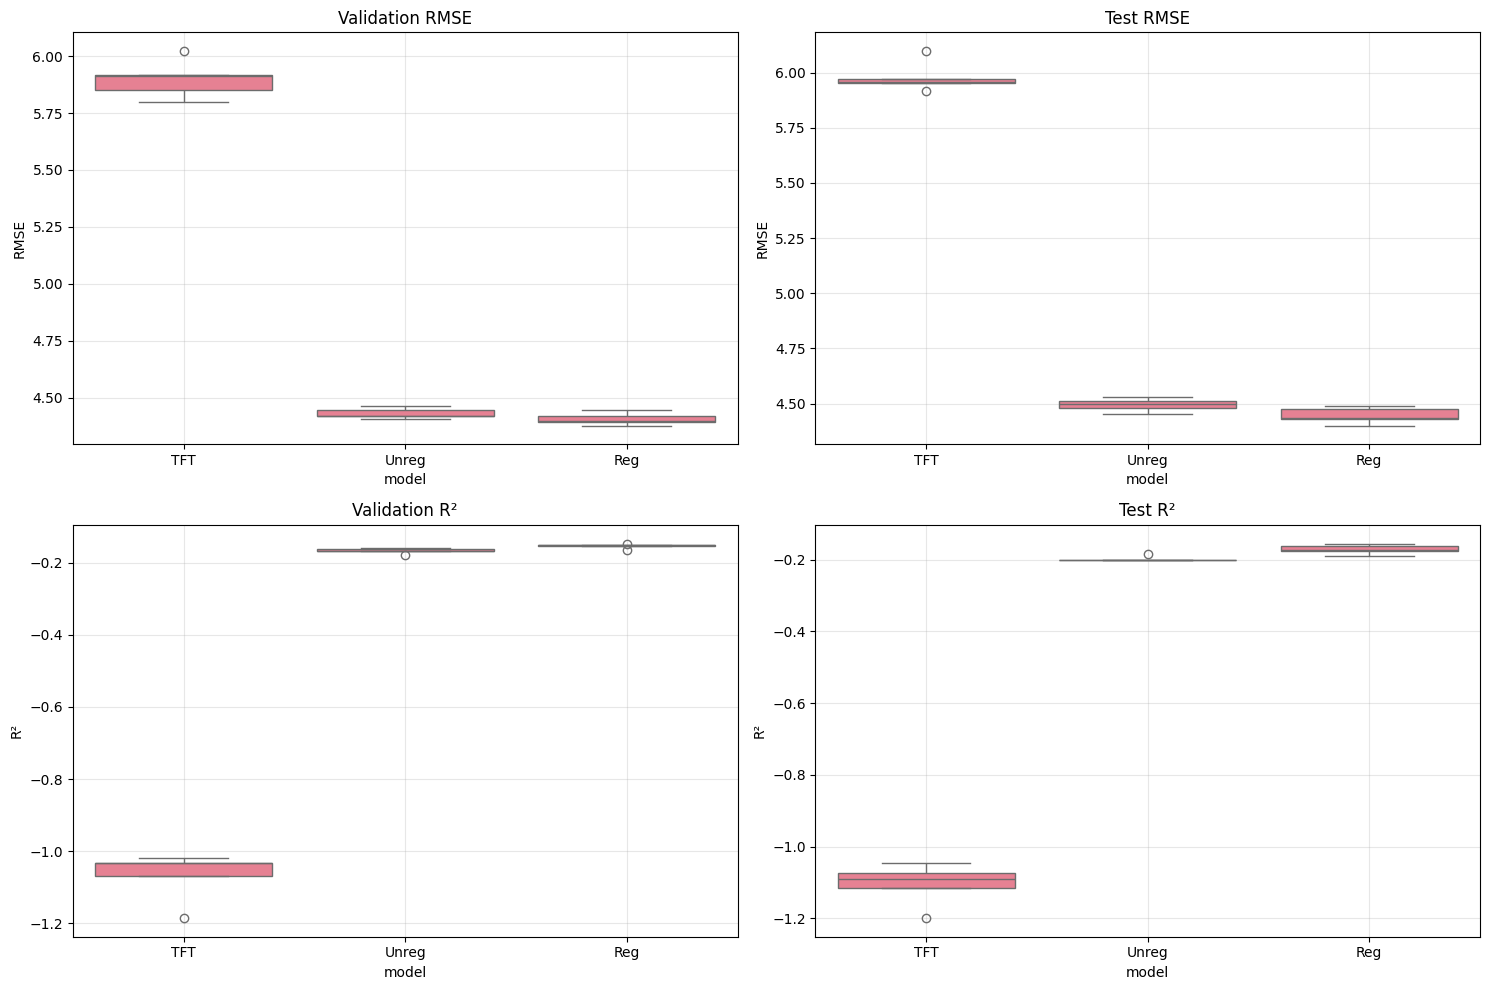


🔧 Best Hyperparameters for Regularized Model:
          tau1         tau2  rmse_val  rmse_test
2   1922.05000  1407.320000  4.377126   4.487084
5    398.31700    59.208800  4.394606   4.431344
8      1.39591     0.517348  4.396885   4.433803
11   634.87200    11.884400  4.443672   4.473491
14   439.42900     0.011475  4.417748   4.400656


In [10]:
# Load results
results_df = pd.read_csv("metrics_summary_TFT.csv")
print("📊 Results Summary:")
print(results_df.groupby('model')[['rmse_val', 'rmse_test', 'r2_val', 'r2_test']].mean())

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE comparison
sns.boxplot(data=results_df, x='model', y='rmse_val', ax=axes[0,0])
axes[0,0].set_title('Validation RMSE')
axes[0,0].set_ylabel('RMSE')
axes[0,0].grid(True, alpha=0.3)

sns.boxplot(data=results_df, x='model', y='rmse_test', ax=axes[0,1])
axes[0,1].set_title('Test RMSE')
axes[0,1].set_ylabel('RMSE')
axes[0,1].grid(True, alpha=0.3)

# R² comparison
sns.boxplot(data=results_df, x='model', y='r2_val', ax=axes[1,0])
axes[1,0].set_title('Validation R²')
axes[1,0].set_ylabel('R²')
axes[1,0].grid(True, alpha=0.3)

sns.boxplot(data=results_df, x='model', y='r2_test', ax=axes[1,1])
axes[1,1].set_title('Test R²')
axes[1,1].set_ylabel('R²')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show best hyperparameters for regularized model
reg_results = results_df[results_df['model'] == 'Reg']
print("\n🔧 Best Hyperparameters for Regularized Model:")
print(reg_results[['tau1', 'tau2', 'rmse_val', 'rmse_test']].head(10))


In [12]:
# Performance comparison summary (TFT baseline)
print("=== Performance Comparison Summary (TFT as baseline) ===")

# Means by model
tft_mean_rmse   = results_df[results_df['model'] == 'TFT']['rmse_test'].mean()
unreg_mean_rmse = results_df[results_df['model'] == 'Unreg']['rmse_test'].mean()
reg_mean_rmse   = results_df[results_df['model'] == 'Reg']['rmse_test'].mean()

print(f"TFT (baseline)  - Mean Test RMSE: {tft_mean_rmse:.4f}")
print(f"Unregularized   - Mean Test RMSE: {unreg_mean_rmse:.4f} "
      f"({(1 - unreg_mean_rmse/tft_mean_rmse)*100:.1f}% improvement vs TFT)")
print(f"Regularized     - Mean Test RMSE: {reg_mean_rmse:.4f} "
      f"({(1 - reg_mean_rmse/tft_mean_rmse)*100:.1f}% improvement vs TFT)")

# Statistical significance test (paired by seed): TFT vs Regularized
from scipy import stats

pivot = results_df.pivot_table(index='seed', columns='model', values='rmse_test', aggfunc='mean')
paired = pivot.dropna(subset=['TFT', 'Reg'])  # keep only seeds that have both
t_stat, p_value = stats.ttest_rel(paired['TFT'].values, paired['Reg'].values)

print(f"\nStatistical Test (TFT vs Regularized):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.8f}")
print(f"  Significant improvement: {'Yes' if p_value < 0.05 else 'No'}")


=== Performance Comparison Summary (TFT as baseline) ===
TFT (baseline)  - Mean Test RMSE: 5.9793
Unregularized   - Mean Test RMSE: 4.4937 (24.8% improvement vs TFT)
Regularized     - Mean Test RMSE: 4.4453 (25.7% improvement vs TFT)

Statistical Test (TFT vs Regularized):
  t-statistic: 38.4935
  p-value: 0.00000272
  Significant improvement: Yes
